# Tree segmentation with multitemporal Sentinel 1/2 imagery

## John Brandt
## April 02, 2020

## Overview

This notebook contains the TensorFlow model training and prediction used to segment trees for [Restoration Mapper](https://restorationmapper.org). The notebook uses tensorflow 1.13.1 and additionally relies on Keras and tflearn. 

## Table of Contents

- Package loading
- Utility scripts
- Hyperparameter definitions
- Custom tensorflow layer functions
- Tensorflow graph creation
- Data loading
- Data preprocessing
- Equibatch creation
- Loss definition
- Tensorflow graph initialization
- Training
- Model validation
- Sanity Checks

## Package Loading

In [1]:
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from time import sleep

import keras
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.python.keras.activations import selu
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import conv2d

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from tensorflow.contrib.framework import arg_scope
from keras.regularizers import l1
from tensorflow.layers import batch_normalization
from tensorflow.python.util import deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


## Utility scripts

In [2]:
%run ../src/layers/zoneout.py
%run ../src/layers/convgru.py
%run ../src/layers/adabound.py
%run ../src/layers/dropblock.py
%run ../src/layers/extra_layers.py
%run ../src/preprocessing/indices.py
%run ../src/preprocessing/slope.py
%run ../src/utils/metrics.py
%run ../src/not_for_release/lovasz.py

# Hyperparameter definitions

In [3]:
ZONE_OUT_PROB = 0.20 #0.2 for master model
GRU_FILTERS = 32
FPA_FILTERS = 28
OUT_FILTERS = 32
AVERAGE_GRU_FILTERS = True
ACTIVATION_FUNCTION = 'relu'

INITIAL_LR = 1e-4
FINAL_LR = 2e-2
DROPBLOCK_MAXSIZE = 5
DECONV = 'bilinear'
N_CONV_BLOCKS = 1
FINAL_ALPHA = 0.7
LABEL_SMOOTHING = 0.10 #0.075 for master
BATCH_RENORM = 'norm'

L2_REG = 0.0
BN_MOMENTUM = 0.9
BATCH_SIZE = 16
MAX_DROPBLOCK = 0.85

gru_flt = 32
fpa_flt = 28
out_conv_flt = 32

IMAGE_SIZE = 16
LABEL_SIZE = 14

# Hyperparameter grid search definitions

In [4]:
# There are 3.8 million combinations of hyperparameters
params = {
    'zone_out' : [0],#range(0, 0.5, 0.1), #6
    'gru_filters': [0], #range(16, 64, 8), #6
    'fpa_filters': [0], #range(24, 48, 4), # 6
    'out_conv_filter': range(16, 64, 16), # 5
    'average_gru_filters': [True, False], # 2
    'activation_function': ['relu', 'selu', 'elu'], # relu > elu ? selu
    'final_lr': [5e-3, 1e-2, 2e-2, 5e-2], # 4
    'dropblock_maxsize': [7, 6, 5, 4, 3], # 5
    'deconv': ['bilinear', 'convtranspose2d'], # 2
    'n_conv_blocks': [3, 2, 1], # 3
    'final_alpha': [0.8, 0.75, 0.7, 0.65, 0.6], #5
    'label_smoothing': [0., 0.025, 0.05, 0.075, 0.10, 0.125],
    'batch_renorm': ['renorm', 'norm']
}

# Custom layer definitions

### Utility blocks (Batch norm, cSSE, etc.)

In [5]:
def Batch_Normalization(x, training, scope, clipping_params):
    '''Batch renormalization layer from tensorflow.layers

         Parameters:
          x (tf.Variable): input layer
          training (tf.Variable): flag to differentiate between train/test ops
          scope (str): tensorflow scope
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): output of batch renormalization
          
         References:
          https://github.com/tensorflow/docs/blob/r1.13/site/en/
          api_docs/python/tf/layers/batch_normalization.md
    '''
    return batch_normalization(inputs=x, 
                               momentum = BN_MOMENTUM, 
                               training=training,
                               renorm = True,
                               reuse=None,
                               renorm_clipping = clipping_params,
                               name = scope)


def calc_renorm_params(epoch, n_samples, batch_size, k = 0):
    '''Calculates the clipping parameters for renormalization
       based on the learning schedule outlined in the original paper
       where rmax is initialized to 1, dmax to 0, rmin to 0,
       (effectively batch normalization), and then rmax and dmax
       are gradually reaxed to 3 and 5 over 40k and 25k steps,
       respectively. In this case, 40k has been reduced to 30k, and 25k
       has been reduced to 20k.

         Parameters:
          epoch (int): number of current training epoch
                       if testing, epoch number of model used
          n_samples (int): total number of training samples
          batch_size (int): training batch size 

         Returns:
          rmax (float)
          dmax (float)
          rmin (float)
    '''
    step = epoch * (n_samples // batch_size)
    step += k
    if step < 2500:
        rmax = 1.
        dmax = 0.
        rmin = 0.
    if step >= 2500:
        rmax = np.min([1 + 2*((step-2500)/20000), 3])
        dmax = np.min([1 + 5*((step-2500)/15000), 5])
        rmin = 0.
    return rmax, dmax, rmin

def cse_block(prevlayer, prefix):
    '''Channel excitation and spatial squeeze layer. 
       Calculates the mean of the spatial dimensions and then learns
       two dense layers, one with relu, and one with sigmoid, to rerank the
       input channels
       
         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the cse_block
    '''
    mean = Lambda(lambda xin: K.mean(xin, axis=[1, 2]))(prevlayer)
    lin1 = Dense(K.int_shape(prevlayer)[3] // 2, name=prefix + 'cse_lin1', activation='relu')(mean)
    lin2 = Dense(K.int_shape(prevlayer)[3], name=prefix + 'cse_lin2', activation='sigmoid')(lin1)
    x = Multiply()([prevlayer, lin2])
    return x


def sse_block(prevlayer, prefix):
    '''Spatial excitation and channel squeeze layer.
       Calculates a 1x1 convolution with sigmoid activation to create a 
       spatial map that is multiplied by the input layer

         Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): output of the sse_block
    '''
    conv = Conv2D(1, (1, 1), padding="same", kernel_initializer="glorot_uniform",
                  activation='sigmoid', strides=(1, 1),
                  name=prefix + "_conv")(prevlayer)
    conv = Multiply(name=prefix + "_mul")([prevlayer, conv])
    return conv


def csse_block(x, prefix):
    '''Implementation of Concurrent Spatial and Channel 
       ‘Squeeze & Excitation’ in Fully Convolutional Networks
    
        Parameters:
          prevlayer (tf.Variable): input layer
          prefix (str): prefix for tensorflow scope

         Returns:
          x (tf.Variable): added output of cse and sse block
          
         References:
          https://arxiv.org/abs/1803.02579
    '''
    cse = cse_block(x, prefix)
    sse = sse_block(x, prefix)
    x = Add(name=prefix + "_csse_mul")([cse, sse])

    return x

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')

### Conv GRU Block

In [6]:
def gru_block(inp, length, size, flt, scope, train, normalize = True):
    '''Bidirectional convolutional GRU block with 
       zoneout and CSSE blocks in each time step

         Parameters:
          inp (tf.Variable): (B, T, H, W, C) layer
          length (tf.Variable): (B, T) layer denoting number of
                                steps per sample
          size (int): kernel size of convolution
          flt (int): number of convolution filters
          scope (str): tensorflow variable scope
          train (tf.Bool): flag to differentiate between train/test ops
          normalize (bool): whether to compute layer normalization

         Returns:
          gru (tf.Variable): (B, H, W, flt*2) bi-gru output
          steps (tf.Variable): (B, T, H, W, flt*2) output of each step
    '''
    with tf.variable_scope(scope):
        print("GRU input shape {}, zoneout: {}".format(inp.shape, ZONE_OUT_PROB))
        cell_fw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_bw = ConvGRUCell(shape = size, filters = flt,
                           kernel = [3, 3], padding = 'VALID', normalize = normalize, sse = True)
        cell_fw = ZoneoutWrapper(
           cell_fw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        cell_bw = ZoneoutWrapper(
            cell_bw, zoneout_drop_prob = ZONE_OUT_PROB, is_training = train)
        steps, out = convGRU(inp, cell_fw, cell_bw, length)
        gru = tf.concat(out, axis = -1)
        steps = tf.concat(steps, axis = -1)
        print("Down block output shape {}".format(gru.shape))
    return gru, steps

### Conv blocks

In [7]:
def conv_selu(inp, is_training, kernel_size, scope,
                filter_count = 16, pad = True, padding = 'valid', dilated = False,
                activation = True):
    '''Convolutional 2D layer with SELU activation and Lecun normal initialization
       with no batch norm. Only used if params['activation'] = 'selu'

         Parameters:
          inp (tf.Variable): (B, H, W, C) input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): kernel size of convolution
          scope (str): tensorflow variable scope
          filter_count (int): number of convolution filters
          pad (bool): whether or not to reflect pad input
          padding (str): one of ['valid', 'same']
          dilated (bool): whether to perform atruous convolution
          activation (bool): whether to activate output

         Returns:
          conv (tf.Variable): output of Conv2D -> SELU
          
         References:
          https://arxiv.org/abs/1706.02515
    '''
    if activation:
        act = selu
    else:
        act = None
    if not dilated:
        padded = ReflectionPadding2D((1, 1,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    if not dilated and not pad:
        conv = Conv2D(filters = filter_count, kernel_size = (kernel_size, kernel_size), activation = act,
                        padding = padding, kernel_initializer = lecun_normal())(inp)
    if dilated:
        padded = ReflectionPadding2D((2, 2,))(inp)
        conv = Conv2D(filters = filter_count, kernel_size = (3, 3), activation = act, dilation_rate = (2, 2),
                        padding = padding, kernel_initializer = lecun_normal())(padded)
    return conv

def conv_bn_relu(inp, 
                 is_training, 
                 kernel_size,
                 scope,
                 filters, 
                 clipping_params,
                 keep_rate,
                 stride = (1, 1),
                 activation = True,
                 use_bias = False,
                 batch_norm = True,
                 dropblock = True,
                 csse = True):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.

         Parameters:
          inp (tf.Variable): input layer
          is_training (str): flag to differentiate between train/test ops
          kernel_size (int): size of convolution
          scope (str): tensorflow variable scope
          filters (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization
          activation (bool): whether to apply RELU
          use_bias (str): whether to use bias. Should always be false

         Returns:
          bn (tf.Variable): output of Conv2D -> Batch Norm -> RELU
        
         References:
          http://papers.nips.cc/paper/8271-dropblock-a-regularization-
              method-for-convolutional-networks.pdf
          https://arxiv.org/abs/1702.03275
          
    '''
    
    bn_flag = "Batch Renorm" if batch_norm else ""
    activation_flag = "RELU" if activation else "Linear"
    csse_flag = "CSSE" if csse else "No CSSE"
    bias_flag = "Bias" if use_bias else "NoBias"
    drop_flag = "DropBlock" if dropblock else "NoDrop"
        
    
    print("{} {} Conv 2D {} {} {} {} {}".format(scope, kernel_size,
                                                   bn_flag, activation_flag,
                                                   csse_flag, bias_flag, drop_flag))
    
    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if batch_norm:
        conv = Batch_Normalization(conv, is_training, scope, clipping_params)
    if activation:
        conv = tf.nn.relu(conv)
    if csse:
        conv = csse_block(conv, 'csse_' + scope)
    if dropblock: 
        with tf.variable_scope(scope + "_drop"):
            drop_block = DropBlock2D(keep_prob=keep_rate, block_size=4)
            conv = drop_block(conv, is_training)
    return conv


def create_deconv_init(filter_size, num_channels):
    '''Initializes a kernel weight matrix with a bilinear deconvolution
    
         Parameters:
          filter_size (int): kernel size of convolution
          num_channels (int): number of filters for convolution

         Returns:
          bilinear_init (tf.Variable): [filter_size, filter_size, num_channels] kernel
    '''
    bilinear_kernel = np.zeros([filter_size, filter_size], dtype=np.float32)
    scale_factor = (filter_size + 1) // 2
    if filter_size % 2 == 1:
        center = scale_factor - 1
    else:
        center = scale_factor - 0.5
    for x in range(filter_size):
        for y in range(filter_size):
            bilinear_kernel[x,y] = (1 - abs(x - center) / scale_factor) * \
                                   (1 - abs(y - center) / scale_factor)
    weights = np.zeros((filter_size, filter_size, num_channels, num_channels))
    for i in range(num_channels):
        weights[:, :, i, i] = bilinear_kernel

    #assign numpy array to constant_initalizer and pass to get_variable
    bilinear_init = tf.constant_initializer(value=weights, dtype=tf.float32)
    return bilinear_init

def get_deconv2d(inp, filter_count, num_channels, scope, is_training, clipping_params):
    '''Creates a deconvolution layer with Conv2DTranspose. Following recent
       recommendations to use 4 kernel, 2 stride to avoid artifacts. 
       Initialize kernel with bilinear upsampling.

         Parameters:
          inp (tf.Variable): input tensorflow layer (B, X, Y, C) shape
          filter_count (int): number of filters for convolution
          num_channels (int): number of output channels
          scope (str): tensorflow variable scope
          is_training (str): flag to differentiate between train/test ops
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          x (tf.Variable): layer with (B, x * 2, y * 2, C) shape
          
         References:
          https://distill.pub/2016/deconv-checkerboard/
    '''
    bilinear_init = create_deconv_init(4, filter_count)
    x = tf.keras.layers.Conv2DTranspose(filters = filter_count, kernel_size = (4, 4),
                                        strides=(2, 2), padding='same', 
                                        use_bias = False,
                                        kernel_initializer = bilinear_init)(inp)
    #x = ELU()(x)
    #x = tf.nn.relu(x)
    x = Batch_Normalization(x, training=is_training, scope = scope + "bn", clipping_params = clipping_params)
    return x
    
def fpa(inp, is_training, filter_count, clipping_params, 
        keep_rate, upsample = "upconv"):
    '''Feature pyramid attention layer block, that allows for cross-scale combination
       of different size features without making blurry feature maps.

         Parameters:
          inp (tf.Variable): input tensorflow layer
          is_training (str): flag to differentiate between train/test ops
          filter_count (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          concat_1 (tf.Variable): output of FPA
          
         References:
          https://arxiv.org/abs/1805.10180
    '''
    one = conv_bn_relu(inp = inp, is_training = is_training, 
                       kernel_size = 1, scope =  'forward1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True,
                       dropblock = False,
                       csse = False)
    
    seven = conv_bn_relu(inp = inp_pad, is_training = is_training, 
                       kernel_size = 7, scope =  'down1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    seven_f = conv_bn_relu(inp = seven, is_training = is_training, 
                       kernel_size = 7, scope =  'down1_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    five = conv_bn_relu(inp = seven, is_training = is_training, 
                       kernel_size = 5, scope =  'down2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    five_f = conv_bn_relu(inp = five, is_training = is_training, 
                       kernel_size = 5, scope =  'down2_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    three = conv_bn_relu(inp = five, is_training = is_training, 
                       kernel_size = 3, scope =  'down3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    three_f = conv_bn_relu(inp = three, is_training = is_training, 
                       kernel_size = 3, scope =  'down3_f', stride = (2, 2),
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
        
    
    if upsample == 'upconv' or 'bilinear':
        three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_f)
        if upsample == 'upconv':
            three_up = ReflectionPadding2D((1, 1,))(three_up)
            three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True,
                       csse = False, dropblock = False)
            
            # 4x4
            three_up = tf.nn.relu(tf.add(three_up, five_f))
            
    
    if upsample == 'upconv' or "bilinear":
        five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_up)
        if upsample == 'upconv':
            five_up = ReflectionPadding2D((1, 1,))(five_up)
            five_up = conv_bn_relu(inp = five_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            five_up = tf.nn.relu(tf.add(five_up, seven_f))
            
    if upsample == 'upconv' or "bilinear":
        seven_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(five_up)
        if upsample == 'upconv':
            seven_up = ReflectionPadding2D((1, 1,))(seven_up)
            seven_up = conv_bn_relu(inp = seven_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            
            
            

    
    print("One: {}".format(one.shape))
    print("Seven: {}".format(seven.shape))
    print("Seven f: {}".format(seven_f.shape))
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    print("Three: {}".format(three.shape))
    print("Three_f: {}".format(three_f.shape))
    print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    print("Seven_up: {}".format(seven_up.shape))
    
    # top block

    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_relu(inp = tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                       is_training = is_training, 
    #                   kernel_size = 1, scope =  'topconv',
    #                   filters = filter_count, clipping_params = clipping_params,
    #                   keep_rate = keep_rate, activation = False,
    #                   use_bias = False, batch_norm = True, 
    #                   csse = False, dropblock = False)
    #one_top = conv_bn_relu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    ##                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    
    seven_up = tf.multiply(one, seven_up)
    out = tf.nn.relu(seven_up + four_top)
    return out


In [8]:
def fpa(inp, is_training, filter_count, clipping_params, 
        keep_rate, upsample = "upconv"):
    '''Feature pyramid attention layer block, that allows for cross-scale combination
       of different size features without making blurry feature maps.

         Parameters:
          inp (tf.Variable): input tensorflow layer
          is_training (str): flag to differentiate between train/test ops
          filter_count (int): number of filters for convolution
          clipping_params (dict): specifies clipping of 
                                  rmax, dmax, rmin for renormalization

         Returns:
          concat_1 (tf.Variable): output of FPA
          
         References:
          https://arxiv.org/abs/1805.10180
    '''
    one = conv_bn_relu(inp = inp, is_training = is_training, 
                       kernel_size = 1, scope =  'forward1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True,
                       dropblock = False,
                       csse = False)
    inp_pad = ReflectionPadding2D(padding = (2, 2))(inp)
    seven = conv_bn_relu(inp = inp_pad, is_training = is_training, 
                       kernel_size = 5, scope =  'down1', stride = (2, 2),
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    seven_pad = ReflectionPadding2D(padding = (2, 2))(seven)
    seven_f = conv_bn_relu(inp = seven_pad, is_training = is_training, 
                       kernel_size = 5, scope =  'down1_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    
    print("Seven: {}".format(seven.shape))
    print("Seven f: {}".format(seven_f.shape))
    
    five_pad = ReflectionPadding2D(padding = (1, 1))(seven)
    five = conv_bn_relu(inp = five_pad, is_training = is_training,  stride = (2, 2),
                       kernel_size = 3, scope =  'down2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    five_pad2 = ReflectionPadding2D(padding = (1, 1))(five)
    five_f = conv_bn_relu(inp = five_pad2, is_training = is_training, 
                       kernel_size = 3, scope =  'down2_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = False, dropblock = False)
    print("Five: {}".format(five.shape))
    print("Five_F: {}".format(five_f.shape))
    '''
    three_pad = ReflectionPadding2D(padding = (1, 1))(five)
    three = conv_bn_relu(inp = three_pad, is_training = is_training,  stride = (2, 2),
                       kernel_size = 3, scope =  'down3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
    
    three_pad2 = ReflectionPadding2D(padding = (1, 1))(three)
    three_f = conv_bn_relu(inp = three_pad2, is_training = is_training, 
                       kernel_size = 3, scope =  'down3_f',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = False,
                       use_bias = False, batch_norm = True, csse = True, dropblock = False)
        
    
    if upsample == 'upconv' or 'bilinear':
        three_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'bilinear')(three_f)
        if upsample == 'upconv':
            three_up = ReflectionPadding2D((1, 1,))(three_up)
            three_up = conv_bn_relu(inp = three_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv1',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True,
                       csse = False, dropblock = False)
            
            # 4x4
            three_up = tf.nn.relu(tf.add(three_up, five_f))
    '''        
    
    if upsample == 'upconv' or "bilinear":
        five_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(five)
        if upsample == 'upconv':
            five_up = ReflectionPadding2D((1, 1,))(five_up)
            five_up = conv_bn_relu(inp = five_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv2',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            five_up = tf.nn.relu(tf.add(five_up, seven_f))
            
    if upsample == 'upconv' or "bilinear":
        seven_up = tf.keras.layers.UpSampling2D((2, 2), interpolation = 'nearest')(five_up)
        if upsample == 'upconv':
            seven_up = ReflectionPadding2D((1, 1,))(seven_up)
            seven_up = conv_bn_relu(inp = seven_up, is_training = is_training, 
                       kernel_size = 3, scope =  'upconv3',
                       filters = filter_count, clipping_params = clipping_params,
                       keep_rate = keep_rate, activation = True,
                       use_bias = False, batch_norm = True, 
                       csse = False, dropblock = False)
            
            
            

    
    print("One: {}".format(one.shape))
    
    
   # print("Three: {}".format(three.shape))
    #print("Three_f: {}".format(three_f.shape))
    #print("Three_up: {}".format(three_up.shape))
    print("Five_up: {}".format(five_up.shape))
    print("Seven_up: {}".format(seven_up.shape))
    
    # top block

    #pooled = tf.keras.layers.GlobalAveragePooling2D()(inp)
    #one_top = conv_bn_relu(inp = tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    #                       is_training = is_training, 
    #                   kernel_size = 1, scope =  'topconv',
    #                   filters = filter_count, clipping_params = clipping_params,
    #                   keep_rate = keep_rate, activation = False,
    #                   use_bias = False, batch_norm = True, 
    #                   csse = False, dropblock = False)
    #one_top = conv_bn_relu(tf.reshape(pooled, (-1, 1, 1, pooled.shape[-1])),
    ##                      is_training, 1, 'top1', filter_count, pad = False)
    #four_top = tf.keras.layers.UpSampling2D((16, 16))(one_top)
    
    #seven_up = tf.multiply(one, seven_up)
    out = tf.nn.relu(tf.multiply(seven_up, one))
    return out



# Model definition

## Placeholders

In [9]:
n_bands = 16 # 16 for master model
reg = keras.regularizers.l2(L2_REG) # for GRU
inp = tf.placeholder(tf.float32, shape=(None, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands))
length = tf.placeholder(tf.int32, shape = (None, 1))
labels = tf.placeholder(tf.float32, shape=(None, 14, 14))#, 1))
keep_rate = tf.placeholder_with_default(1.0, ()) # For DropBlock
length2 = tf.reshape(length, (-1,)) # Remove
is_training = tf.placeholder_with_default(False, (), 'is_training') # For BN, DropBlock
alpha = tf.placeholder(tf.float32, shape = ()) # For loss scheduling
ft_lr = tf.placeholder_with_default(0.001, shape = ()) # For loss scheduling
loss_weight = tf.placeholder_with_default(1.0, shape = ())
beta_ = tf.placeholder_with_default(0.0, shape = ())




In [10]:
rmax = tf.placeholder(tf.float32, shape = ())
rmin = tf.placeholder(tf.float32, shape = ())
dmax = tf.placeholder(tf.float32, shape = ())

clipping_params = {
    'rmax': rmax,
    'rmin': rmin,
    'dmax': dmax
}

## Layers

In [11]:
# Split out slope for temporal modeling
inp_first_half = inp[:, :, :, :, :10]
inp_second_half = inp[:, :, :, :, 11:]
no_dem = tf.concat([inp_first_half, inp_second_half], axis = -1)
dem = tf.reshape(tf.reduce_mean(inp[:, :, :, :, 10], axis = 1), (-1, 16, 16, 1))
gru_out, steps = gru_block(inp = no_dem, length = length2, 
                            size = [16, 16], 
                            flt = gru_flt, 
                            scope = 'down_16', 
                            train = is_training)

#steps = tf.reduce_mean(steps, axis = 1)
#mean = tf.reduce_mean(inp, axis = 1)
#print("Mean: ", mean.shape)
gru_out = tf.concat([gru_out, dem], axis = -1)

# CSSE, Drop
csse1 = csse_block(gru_out, 'csse1')
drop_block1 = DropBlock2D(keep_prob=keep_rate, block_size=4)
csse1 = drop_block1(csse1, is_training)

# FPA, CSSE, 4x4 Drop block
fpa1 = fpa(csse1, is_training, fpa_flt, clipping_params, keep_rate)
csse2 = csse_block(fpa1, 'csse2')

drop_block2 = DropBlock2D(keep_prob=keep_rate, block_size=4)
csse2 = drop_block2(csse2, is_training)


# Skip connect
x = tf.concat([csse2, csse1], axis = -1)

x = conv_bn_relu(inp = x, 
                 is_training = is_training,
                 kernel_size = 3,
                 scope = "outconv2", 
                 filters = out_conv_flt, 
                 clipping_params = clipping_params,
                 activation = True,
                 keep_rate = keep_rate, 
                 use_bias = False, dropblock = False,
                 batch_norm = True, csse = False)

print("Initializing last sigmoid bias with -2.94 constant")
init = tf.constant_initializer([-np.log(0.7/0.3)]) # For focal loss
fm = Conv2D(filters = 1,
            kernel_size = (1, 1), 
            padding = 'valid',
            activation = 'sigmoid',
            bias_initializer = init,
           )(x) # For focal loss

GRU input shape (?, 24, 16, 16, 15), zoneout: 0.2
(3, 3, 47, 64)
(3, 3, 47, 64)
Down block output shape (?, 16, 16, 64)
forward1 1 Conv 2D Batch Renorm Linear No CSSE NoBias NoDrop
down1 5 Conv 2D Batch Renorm RELU CSSE NoBias NoDrop
down1_f 5 Conv 2D Batch Renorm Linear No CSSE NoBias NoDrop
Seven: (?, 8, 8, 28)
Seven f: (?, 8, 8, 28)
down2 3 Conv 2D Batch Renorm RELU CSSE NoBias NoDrop
down2_f 3 Conv 2D Batch Renorm Linear No CSSE NoBias NoDrop
Five: (?, 4, 4, 28)
Five_F: (?, 4, 4, 28)
upconv2 3 Conv 2D Batch Renorm RELU No CSSE NoBias NoDrop
upconv3 3 Conv 2D Batch Renorm RELU No CSSE NoBias NoDrop
One: (?, 16, 16, 28)
Five_up: (?, 8, 8, 28)
Seven_up: (?, 16, 16, 28)
outconv2 3 Conv 2D Batch Renorm RELU No CSSE NoBias NoDrop
Initializing last sigmoid bias with -2.94 constant


In [12]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 210969 parameters


# Data loading

*  Load in CSV data from Collect Earth
*  Reconstruct the X, Y grid for the Y data per sample
*  Calculate NDVI, EVI, SAVI, BI, MSAVI2, and SI
*  Stack X, Y, length data
*  Apply median filter to DEM

In [13]:
train_x = np.load("../tile_data/processed/data_x_l2a_processed.npy")
train_y = np.load("../tile_data/processed/data_y_l2a_processed.npy")
train_l = np.load("../tile_data/processed/length_l2a_processed.npy")

train_x = np.delete(train_x, 14, -1) # test not deleting the SI inde

In [14]:
#to_delete = [139, 630, 1100, 1474, 1964, 669]
#train_x = np.delete(train_x, to_delete, 0)
#train_y = np.delete(train_y, to_delete, 0)
#train_l = np.delete(train_l, to_delete)

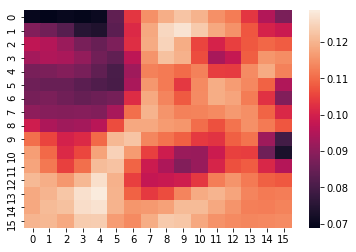

In [15]:

sns.heatmap(train_x[22, 23, :, :, 1])

In [16]:
holdout_for_vis = np.copy(train_x[65, 0, :, :, 10])
for sample in tnrange(0, len(train_x)):
    filtered = median_filter(train_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    train_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
print(train_x.shape)


(1517, 24, 16, 16, 16)


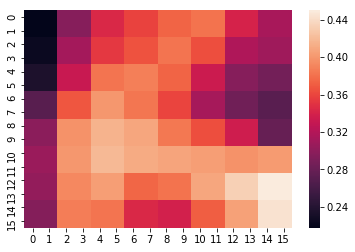

In [17]:
sns.heatmap(train_x[65, 0, :, :, 10], vmax = 0.45)

# Data preprocessing

*  Identify and remove samples with time steps / channels that have a 0. or 1. value, which indicates missing data
*  Identify and remove samples with time steps / channels with no variation, which indicates missing data
*  Identify and remove samples with values above or below the allowable values for the band
*  Identify and remove samples with null data, or samples with extreme band 0 data (which squash all the "clean" samples)
*  Smooth per-pixel temporal data with Whittaker smoother, d = 2, lambda = 0.5 to reduce sample noise

In [18]:
below_1 = [i for i, val in enumerate(train_x[:, :, :, :, :10]) if np.min(val) < -2]
above_1 = [i for i, val in enumerate(train_x[:, :, :, :, :10]) if np.max(val) > 2]
min_vals = [np.min(val) for i, val in enumerate(train_x[:, :, :, :, :10]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(train_x[:, :, :, :, :10]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(train_x) if np.sum(np.isnan(val)) > 100]
oob_vals = [i for i, val in enumerate(train_x) if np.max(val[:, :, :, 0]) > 0.7]

outliers = below_1 + above_1 + nans + oob_vals
outliers = list(set(outliers))
print("Removing {} outlying training data points".format(len(outliers)))
print("\n")
print(sorted(outliers))
train_x = train_x[[x for x in range(0, len(train_x)) if x not in outliers]]
train_y = train_y[[x for x in range(0, len(train_y)) if x not in outliers]]
train_l = train_l[[x for x in range(0, len(train_l)) if x not in outliers]]

Removing 18 outlying training data points


[700, 703, 717, 718, 865, 874, 900, 1047, 1102, 1127, 1129, 1139, 1323, 1330, 1352, 1448, 1461, 1469]


## Temporal Smoothing

In [19]:

min_all = [0.016768555792030362,
 0.031859364002449986,
 0.018888066882654337,
 0.08300588143157157,
 0.04900411763090337,
 0.07196114637821546,
 0.0790915859490633,
 0.08027978003529285,
 0.05206992316991091,
 0.033226898834616644,
 0.0,
 0.0029407649199765626,
 -0.026773188909673434,
 0.0032562207477167242,
 0.006299999542534351,
 4.999999873689376e-05]

max_all = [0.21292338743805878,
 0.29813900702779483,
 0.4300807791948318,
 0.5124803858995437,
 0.4764584118127815,
 0.4890428495407102,
 0.5156670875445272,
 0.5284151314082131,
 0.6588925588130947,
 0.6016234779357905,
 0.37872035768296985,
 0.7223387521306766,
 0.40211242556571936,
 0.6531514992624433,
 0.7853250503540039,
 0.15389999747276306]
#
#min_all = []
#max_all = []
#
for band in tnrange(0, train_x.shape[-1]):
   # mins = np.percentile(train_x[:, :, :, :, band], 1)
   # maxs = np.percentile(train_x[:, :, :, :, band], 99)
    mins = min_all[band]
    maxs = max_all[band]
    #print(mins1 - mins, maxs1 - maxs)
    train_x[:, :, :, :, band] = np.clip(train_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (train_x[:, :, :, :, band] - midrange) / (rng / 2)
    train_x[:, :, :, :, band] = standardized
    
    #min_all.append(mins)
    #max_all.append(maxs)
    
print("The data has been scaled to [{}, {}]".format(np.min(train_x), np.max(train_x)))
print(min_all, max_all)


The data has been scaled to [-1.0000000000000002, 1.0000000000000002]
[0.016768555792030362, 0.031859364002449986, 0.018888066882654337, 0.08300588143157157, 0.04900411763090337, 0.07196114637821546, 0.0790915859490633, 0.08027978003529285, 0.05206992316991091, 0.033226898834616644, 0.0, 0.0029407649199765626, -0.026773188909673434, 0.0032562207477167242, 0.006299999542534351, 4.999999873689376e-05] [0.21292338743805878, 0.29813900702779483, 0.4300807791948318, 0.5124803858995437, 0.4764584118127815, 0.4890428495407102, 0.5156670875445272, 0.5284151314082131, 0.6588925588130947, 0.6016234779357905, 0.37872035768296985, 0.7223387521306766, 0.40211242556571936, 0.6531514992624433, 0.7853250503540039, 0.15389999747276306]


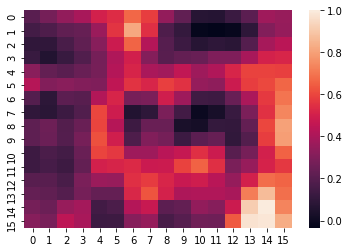

In [20]:
sns.heatmap(train_x[12, 5, :, :, 6])

# Augment training data

Horizontal and vertical flips for 4x augmentation.

**To do**
*  Random guassian noise
*  Brightness, contrast
*  Region swaps (randomply position positive samples at different locations)

## Load and process test data

In [21]:
test_x = np.load("../tile_data/processed/test_x_l2a_processed.npy")
test_y = np.load("../tile_data/processed/test_y_l2a_processed.npy")
test_lengths = np.load("../tile_data/processed/test_length_l2a_processed.npy")


#test_x = np.delete(test_x, [975, 1026], 0)
#test_y = np.delete(test_y, [975, 1026], 0)
#test_lengths = np.delete(test_lengths, [975, 1026], 0)

test_x = np.delete(test_x, 14, -1)

below_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.66]
above_1 = [i for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.66]
min_vals = [np.min(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.min(val) < -1.5]
max_vals = [np.max(val) for i, val in enumerate(test_x[:, :, :, :, :-2]) if np.max(val) > 1.5]
nans = [i for i, val in enumerate(test_x) if np.sum(np.isnan(val)) > 0]
outliers = below_1 + above_1 + nans
outliers = list(set(outliers))
#outliers = [593, 546, 571]
print("There are {} outliers: {}".format(len(outliers), outliers))
print("\n")
print(min_vals, max_vals)

        
test_x = test_x[[x for x in range(0, len(test_x)) if x not in outliers]]
test_y = test_y[[x for x in range(0, len(test_y)) if x not in outliers]]
test_lengths = test_lengths[[x for x in range(0, len(test_lengths)) if x not in outliers]]

for sample in tnrange(0, len(test_x)):
    filtered = median_filter(test_x[sample, 0, :, :, 10], size = 5)
    filtered = np.reshape(filtered, (8, 2, 8, 2))
    filtered = np.mean(filtered, axis = (1, 3))
    filtered = resize(filtered, (16, 16), 0)
    test_x[sample, :, :, :, 10] = np.stack([filtered] * 24)
    
for band in range(0, test_x.shape[-1]):
    mins = min_all[band]
    maxs = max_all[band]
    test_x[:, :, :, :, band] = np.clip(test_x[:, :, :, :, band], mins, maxs)
    midrange = (maxs + mins) / 2
    rng = maxs - mins
    standardized = (test_x[:, :, :, :, band] - midrange) / (rng / 2)
    test_x[:, :, :, :, band] = standardized
    
    
print("The data has been scaled to [{}, {}]".format(np.min(test_x), np.max(test_x)))
print(test_x.shape)

There are 1 outliers: [105]


[] []



The data has been scaled to [-1.0000000000000002, 1.0000000000000002]
(129, 24, 16, 16, 16)


In [22]:
print("Train and test characteristics:")
print("Train mean Y {}".format(np.mean([np.sum(x) for x in test_y])))
print("Test STD Y {}".format(np.std([np.sum(x) for x in test_y])))
#print("Train number with zero trees {}".format(0.2*len([x for x in data_y[train_ids] if np.sum(x) == 0])))
#print("Test number with zero trees {}".format(0.8*len([x for x in data_y[test_ids] if np.sum(x) == 0])))
print("Train mean NDVI")
print("Test mean NDVI")
#print("There are {} train and {} test samples".format(len(train_ids), len(test_ids)))
#print("There is {} overlap between train and test".format(len([x for x in train_ids if x in test_ids])))

Train and test characteristics:
Train mean Y 78.10852713178295
Test STD Y 69.61335525323862
Train mean NDVI
Test mean NDVI


# Equibatch creation

The modelling approach uses equibatch sampling to ensure that there is a near constant standard deviation of the percent tree cover in the output labels for each batch. This helps ensure that the model performs equally well across gradients of tree cover, by mitigating the random possibility that many batches in a row near the end of sampling may be randomly biased towards a tree cover range.

In [23]:
sums = np.sum(train_y, axis = (1, 2))
percents = [np.percentile(sums, x) for x in range(30, 100, 9)]
print(percents)
print("There are {} zeros".format(len(np.argwhere(sums == 0))))

[14.0, 29.0, 52.0, 79.0, 115.0, 161.0, 194.31999999999994, 196.0]
There are 263 zeros


In [24]:
percents = [14, 29, 56, 83, 122, 180]

In [25]:
train_ids = [x for x in range(0, len(train_y))]

def multiplot(matrices):
    '''Plot multiple heatmaps with subplots
    
         Parameters:
          matrices (list of arrays):

         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4)
    fig.set_size_inches(20, 4)
    for i, matrix in enumerate(matrices):
        sns.heatmap(data = matrix, ax = axs[i], vmin = 0, vmax = 0.9)
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].set_xticks([])

def equibatch(train_ids, p = percents):
    '''Docstring
    
         Parameters:
          train_ids (list):
          p (list):

         Returns:
          equibatches (list):
    '''
    ##percents = [7.0, 15.0, 25.0, 40.0, 60.0, 90.0, 140.0] # overall #0, 3, 7, 12, 20, 30, 50, 70
    percents = [9.0, 18.0, 27.0, 36.0, 54.0, 81.0, 135.0] # sept 16
    percents = [9.0, 19.0, 29.0, 40.0, 64.0, 95.0, 145.0] # sept 28
   # percents =  [7.0, 13.0, 21.0, 33.0, 50.0, 80.0, 130.0] # overall
    #percents = [12.0, 24.0, 36.0, 60.0, 86.0, 125., 170.0] # finetuning
    np.random.shuffle(train_ids)
    ix = train_ids
    percs = [np.sum(x) for x in train_y[ix]]
    ids0 = [x for x, z in zip(ix, percs) if z <= 2]
    ids30 = [x for x, z in zip(ix, percs) if 2 < z <= percents[0]]
    ids40 = [x for x, z in zip(ix, percs) if percents[0] < z <= percents[1]]
    ids50 = [x for x, z in zip(ix, percs) if percents[1] < z <= percents[2]]
    ids60 = [x for x, z in zip(ix, percs) if percents[2] < z <= percents[3]]
    ids70 = [x for x, z in zip(ix, percs) if percents[3] < z <= percents[4]]
    ids80 = [x for x, z in zip(ix, percs) if percents[4] < z <= percents[5]]
    ids90 = [x for x, z in zip(ix, percs) if percents[5] < z <= percents[6]]
    ids100 = [x for x, z in zip(ix, percs) if percents[6] < z]
    
    new_batches = []
    maxes = [len(ids0), len(ids30), len(ids40), len(ids50), len(ids60), len(ids70),
             len(ids80), len(ids90), len(ids100)]
    print(maxes)
    print(sum(maxes))
    cur_ids = [0] * len(maxes)
    iter_len = len(train_ids)//(len(maxes))
    for i in range(0, iter_len):
        for i, val in enumerate(cur_ids):
            if val > maxes[i] - 1:
                cur_ids[i] = 0
        if cur_ids[0] >= (maxes[0] - 2):
            cur_ids[0] = 0
        to_append = [ids0[cur_ids[0]],
                    ids30[cur_ids[1]], ids40[cur_ids[2]],
                    ids50[cur_ids[3]],
                    ids60[cur_ids[4]], ids70[cur_ids[5]], ids80[cur_ids[6]],
                    ids90[cur_ids[7]], ids100[cur_ids[8]]]
        
        np.random.shuffle(to_append)
        new_batches.append(to_append)
        cur_ids = [x + 1 for x in cur_ids]
        #cur_ids[0] += 1
        
    new_batches = [item for sublist in new_batches for item in sublist]
    return new_batches

batch = equibatch(train_ids)

[308, 104, 92, 86, 67, 122, 134, 168, 418]
1499


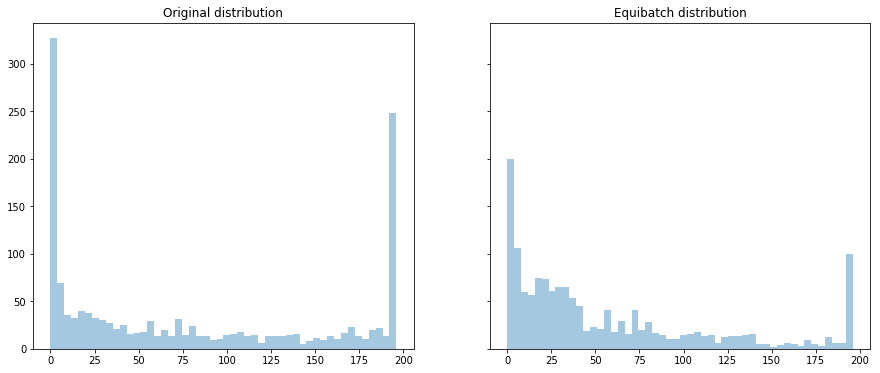

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(15, 6)
sns.distplot(np.sum(train_y, axis = (1, 2)), bins = 50, kde = False, ax = ax1)
ax1.set_title('Original distribution')
ax2.set_title('Equibatch distribution')
sns.distplot(np.sum(train_y[batch], axis = (1, 2)),
             bins = 50, kde = False, ax = ax2)

plt.show()

# Example equibatch

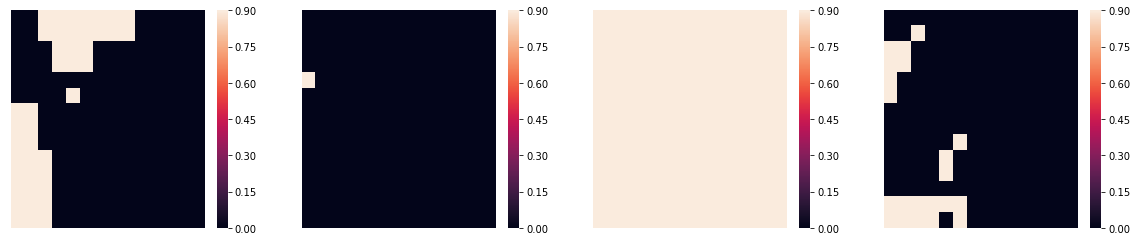

In [27]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[4:8]]])

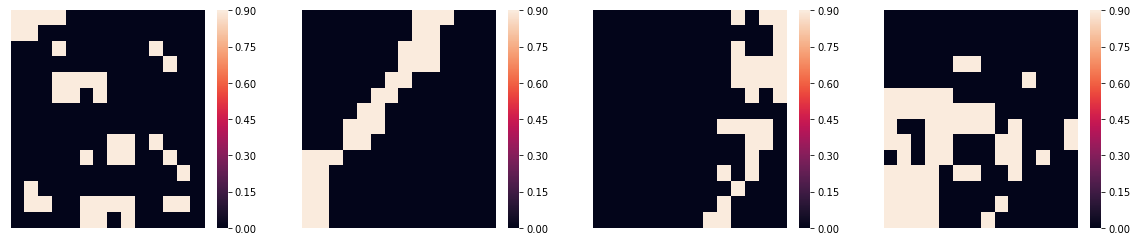

In [28]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[8:12]]])

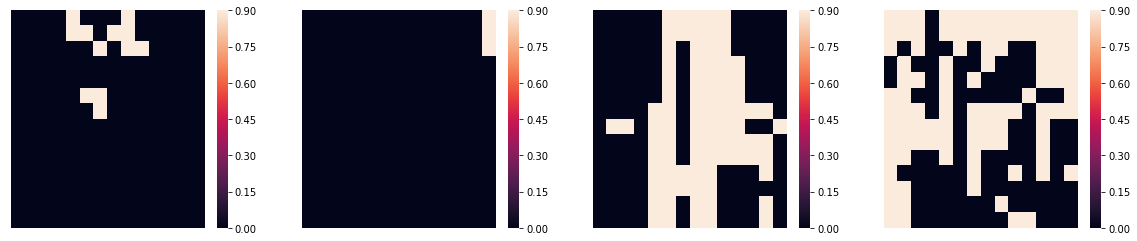

In [29]:
multiplot([x.reshape((14, 14)) for x in train_y[batch[0:4]]])

## Weight cross entropy by effective number of samples

In [30]:
sum_pos = np.sum(train_y[batch])
sum_neg = len(train_y[batch]) * 196 - sum_pos
beta = 0.9999
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos]) / 9
print(samples_per_cls)
effective_num = 1.0 - np.power(beta, samples_per_cls)
print(effective_num)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
print("Neg and pos weights: {}".format(weights))
weight = weights[1] / weights[0]
print(weight)

Beta: 0.9999
[23069.44444444  9466.55555556]
[0.90044647 0.61198174]
Neg and pos weights: [0.40463523 0.59536477]
1.471361651453123


In [31]:
sum_pos = np.sum(train_y)
sum_neg = len(train_y) * 196 - sum_pos
print(sum_pos, sum_neg)
beta = 0.999
print("Beta: {}".format(beta))
samples_per_cls = np.array([sum_neg, sum_pos]) / 9
print(samples_per_cls)
effective_num = 1.0 - np.power(beta, samples_per_cls)
print(effective_num)
weights = (1.0 - beta) / np.array(effective_num)
weights = weights / np.sum(weights)
print("Neg and pos weights: {}".format(weights))
weight = weights[1] / weights[0]
print(weight)
weight = 2.36
print(weight)

120767.0 173037.0
Beta: 0.999
[19226.33333333 13418.55555556]
[1.         0.99999852]
Neg and pos weights: [0.49999963 0.50000037]
1.0000014729141435
2.36


In [32]:
weight = 1.0


In [33]:
print("Baseline: The positive is: {}".format(weights[0]))
print("Baseline: The negative is: {}".format(weights[1]))
print("\n")
print("Balanced: The positive is: {}".format(weight*weights[0]))
print("Balanced: The negative is: {}".format(weights[1]))


Baseline: The positive is: 0.4999996317717353
Baseline: The negative is: 0.5000003682282647


Balanced: The positive is: 0.4999996317717353
Balanced: The negative is: 0.5000003682282647



# Loss definition

The current best loss is a combination of weighted binary cross entropy and per-image Lovasz-Softmax, with a loss schedule with the latter becoming more important each epoch

In [34]:
from keras.losses import binary_crossentropy
import math
from scipy.ndimage import distance_transform_edt as distance

def calc_mask(seg):

    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance = np.expm1(loss_importance)
    loss_importance[:30] = 0.

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        #res[np.where(res == 0)] = -1 * loss_importance[196 - sums]
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    res[np.logical_and(res < 2, res > 0)] = 0.75
    res[np.logical_or(res >= 2, res <= 0)] = 1.

    
    return res# / max_value

def weighted_bce_loss(y_true, y_pred, weight, mask = True, smooth = 0.03):
    '''Calculates the weighted binary cross entropy loss between y_true and
       y_pred with optional masking and smoothing for regularization
       
       For smoothing, we want to weight false positives as less important than
       false negatives, so we smooth false negatives 2x as much. 
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          weight (float):
          mask (arr):
          smooth (float):

         Returns:
          loss (float):
    '''
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    y_true = K.clip(y_true, smooth, 1. - smooth)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        logit_y_pred,
        weight,
    )
    return loss
    #return tf.reduce_mean(loss)

def calc_dist_map(seg):
    '''Utility function for calc_dist_map_batch that calculates the loss
       importance per pixel based on the surface distance function
    
         Parameters:
          seg (arr):
          
         Returns:
          res (arr):
    '''
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)
    loss_importance = np.array([x for x in range(0, 197, 1)])
    loss_importance = loss_importance / 196
    loss_importance[:20] = 0.
    loss_importance[20:60] = np.arange(0, 40, 1) / 40
    loss_importance[60:] = 1.

    mults = np.ones_like(seg)
    ones = np.ones_like(seg)
    for x in range(1, res.shape[0] -1 ):
        for y in range(1, res.shape[0] - 1):
            if seg[x, y] == 1:
                l = seg[x - 1, y]
                r = seg[x + 1, y]
                u = seg[x, y + 1]
                d = seg[x, y - 1]
                lu = seg[x - 1, y + 1]
                ru = seg[x + 1, y + 1]
                rd = seg[x + 1, y - 1]
                ld = seg[x -1, y - 1]
                
                sums = (l + r + u + d)
                sums2 = (l + r + u + d + lu + ru +rd + ld)
                if sums >= 2:
                    mults[x, y] = 1.25
                if sums2 <= 1:
                    ones[x - 1, y] = 0.33
                    ones[x + 1, y] = 0.33
                    ones[x, y + 1] = 0.33
                    ones[x, y - 1] = 0.33
                    ones[x - 1, y + 1] = 0.33
                    ones[x + 1, y + 1] = 0.33
                    ones[x + 1, y - 1] = 0.33
                    ones[x -1, y - 1] = 0.33

    if posmask.any():
        
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask
        sums = int(np.sum(seg))
        # When % = 1, 0 -> 1.75
        # When % = 100, 0 -> 0
        res = np.round(res, 0)
        res[np.where(np.isclose(res, -.41421356, rtol = 1e-2))] = -1
        res[np.where(res == -1)] = -1 * mults[np.where(res == -1)]
        res[np.where(res == 0)] = -1  * mults[np.where(res == 0)]# * loss_importance[196 - sums]
        # When % = 1, 1 -> 0
        # When % = 100, 1 -> 1.75
        res[np.where(res == 1)] = 1 * ones[np.where(res == 1)]
        res[np.where(res == 1)] *= 0.67
        #res[np.where(np.isclose(res, 1.41421356, rtol = 1e-2))] = loss_importance[sums]
        
    res[np.where(res < -3)] = -3
    res[np.where(res > 3)] = 3
    if np.sum(seg) == 196:
        res = np.ones_like(seg)
        res *= -1
    if np.sum(seg) == 0:
        res = np.ones_like(seg)
    return res# / max_value

def calc_lovasz_weight(y_true):
    if np.sum(y_true) > 12:
        return np.array(1., dtype = np.float32)
    else:
        return np.array(0., dtype = np.float32)
    
def calc_bce_weight(y_true):
    if np.sum(y_true) <= 12:
        return np.array(1., dtype = np.float32)
    else:
        return np.array(0., dtype = np.float32)
    
def calc_lovasz_weight_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    lovasz_batch = np.array([calc_lovasz_weight(y)
                     for y in y_true_numpy]).astype(np.float32)
    return lovasz_batch

def calc_bce_weight_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    bce_batch = np.array([calc_bce_weight(y)
                     for y in y_true_numpy]).astype(np.float32)
    return bce_batch
    
    

def calc_dist_map_batch(y_true):
    '''Applies calc_dist_map to each sample in an input batch
    
         Parameters:
          y_true (arr):
          
         Returns:
          loss (arr):
    '''
    y_true_numpy = y_true.numpy()
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)

def surface_loss(y_true, y_pred):
    '''Calculates the mean surface loss for the input batch
       by multiplying the distance map by y_pred
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          loss (arr):
        
         References:
          https://arxiv.org/abs/1812.07032
    '''
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    y_true_dist_map = tf.stack(y_true_dist_map, axis = 0)
    multipled = y_pred * y_true_dist_map
    #loss = tf.reduce_mean(multipled, axis = (1, 2, 3))
    loss = K.mean(multipled)
    return loss

def dice_surf(y_true, y_pred, alpha, weight, batch_size):
    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = 0.03)
    
    def _bce():
        return bce
    
    dices = []
    for x in range(batch_size):
        dice = 1 - dice_loss_tolerance(y_true[x], y_pred[x])
        dices.append(dice)
    dices = tf.reduce_mean(dices)
    surf = surface_loss(y_true, y_pred)
    
    def _surf():
        return ( (1-alpha)*dices + (alpha * surf) )
    
    result = tf.cond(alpha < 0.1, lambda: _bce(), lambda: _surf() )
    return result
    
def bce_surf(y_true, y_pred, alpha, weight, smooth = 0.03, mask = None, ):
    '''Calculates the weighted combination of binary cross entropy and surface loss
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          alpha (float):
          smooth (float):
          weight (float):
          mask (arr):
          
         Returns:
          loss (arr):
    '''

    bce =  weighted_bce_loss(y_true, y_pred, weight, smooth = 0.03)
    bce = tf.reduce_mean(bce)
    print("BCE", bce.shape)
    surf = surface_loss(y_true, y_pred)
    print("SURF", surf.shape)
    return ( (1-alpha)*bce + (alpha * surf) )#global_loss #+ regional_loss


def lovasz_surf(y_true, y_pred, alpha, weight, beta):
    
    lv = lovasz_softmax(probas = y_pred,
                        labels = tf.reshape(y_true, (-1, 14, 14)), 
                        classes=[1],
                        per_image=True) 
    print("Lovasz Shape: ", lv.shape)
    
    bce =  weighted_bce_loss(y_true = y_true, 
                             y_pred = y_pred, 
                             weight = weight,
                             smooth = 0.03)
    print("BCE Shape: ", bce.shape)
    #return tf.reduce_mean(bce)

    
    bce = tf.reduce_mean(bce, axis = (1, 2, 3))
    print("BCE Shape: ", bce.shape)
    surface = surface_loss(y_true, y_pred)
    
    lv_mask = tf.math.reduce_sum(y_true, axis = (1, 2, 3))
    lv_mask = tf.cast(lv_mask, tf.float32)
    lv_mask = tf.math.greater_equal(lv_mask, tf.constant([25.]))
    lv_mask = tf.cast(lv_mask, tf.float32)

    
    bce_mask = tf.math.reduce_sum(y_true, axis = (1, 2, 3))
    bce_mask = tf.cast(bce_mask, tf.float32)
    bce_mask = tf.math.less(bce_mask, tf.constant([25.]))
    bce_mask = tf.cast(bce_mask, tf.float32)
    
    
    lovasz = (lv * lv_mask) + (bce * bce_mask)
    lovasz = tf.reduce_mean(lovasz)
    bce = tf.reduce_mean(bce)
    

    lovasz_portion = (1 - alpha) * lovasz
    lovasz_portion = lovasz_portion * beta
    bce_portion = (1 - alpha) * bce
    bce_portion = bce_portion * (1 - beta)
    surface_portion = alpha * surface
    
    #lovasz_portion = (tf.constant([1.]) - (tf.constant([2.]) * alpha)) * lovasz
    #surface_portion = (tf.constant([2.]) * alpha) * surface
    #non_bce = (alpha) * (lovasz_portion + surface_portion)
    
    result = lovasz_portion + surface_portion + bce_portion
    return result


In [35]:
calc_dist_map(test_y[77])[12, 9]

0.33

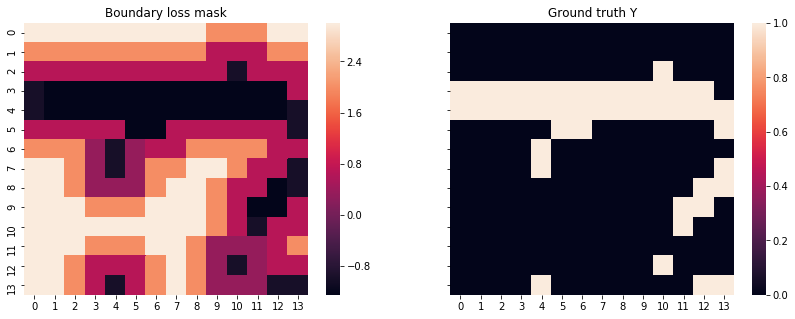

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(14, 5)
sns.heatmap(calc_dist_map(test_y[77]), ax = ax1)
ax2.set_title('Ground truth Y')
ax1.set_title('Boundary loss mask')
sns.heatmap(test_y[77], ax = ax2)
plt.show()

# Evaluation metrics

In [37]:
countries = {'africaeast-test': [0, 34],
 'africawest-test': [35, 96],
 'cameroon-test': [97, 135],
 'ethiopia-test': [136, 248],
 'ghana-test': [249, 282],
 'ghana-test-large': [283, 318],
 'global-test': [319, 460],
 'india-test': [461, 511],
 'kenya-test': [512, 600],
 'lac-north-test': [601, 641],
 'lac-south-test': [642, 683], 'all': [0, 683]}

countries = {'all': [0, 1150]}

def dice_loss(y_true, y_pred):
    '''Calculates the dice score of ground truth and prediction arrays
    
         Parameters:
          y_true (arr):
          y_pred (arr):
          
         Returns:
          metric (arr):
    '''
    numerator = 2 * np.sum(y_true * y_pred, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)

def dice_loss_tolerance(y_true, y_pred):
    numerator_data = np.zeros_like(y_true)
    for x in range(y_true.shape[0]):
        for y in range(y_true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([y_true.shape[0], y+2])
            max_x = np.min([y_true.shape[0], x+2])
            if y_true[x, y] == 1:
                numerator_data[x, y] = np.max(y_pred[min_x:max_x, min_y:max_y])
                
    numerator = 2 * np.sum(y_true * numerator_data, axis=-1)
    denominator = np.sum(y_true + y_pred, axis=-1)
    return (numerator + 1) / (denominator + 1)
                    
            
        
def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1                
                
    precision =  np.sum(tp) / (np.sum(tp) + np.sum(fp))
    recall = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    f1 = 2 * ((precision * recall) / (precision + recall))
    return np.sum(tp), np.sum(fp), np.sum(fn)

def recover_patches(arr, thresh_p):
    sum1 = np.sum(arr)
    thresh = thresh_p / 2

    for window_x in range(2, arr.shape[0]-2, 1):
        for window_y in range(2, arr.shape[1]-2, 1):
            l, r, u, d =  False, False, False, False
            cur_window = arr[window_x-2:window_x+3, window_y-2:window_y+3]
            hor_vert_neighbors = False
            if (cur_window[2, 2] > thresh and
                cur_window[2, 2] < thresh_p):
                if cur_window[3, 2] > thresh * 2 and cur_window[4, 2] < thresh * 2 :
                    hor_vert_neighbors = True
                    r = True
                if cur_window[1, 2] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                    hor_vert_neighbors = True
                    l = True
                if cur_window[2, 3] > thresh * 2 and cur_window[2, 4] < thresh * 2:
                    hor_vert_neighbors = True
                    d = True
                if cur_window[2, 1] > thresh * 2 and cur_window[2, 0] < thresh * 2:
                    hor_vert_neighbors = True
                    u = True
            passes = False
            if r and not l:
                passes = True
            if l and not r:
                passes = True
            if d and not u:
                passes = True
            if u and not d:
                passes = True

            if passes:
                if r:
                    if cur_window[1, 1] < thresh * 2 and cur_window[1, 3] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)

                if l:
                    if cur_window[3, 1] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)

                if u:
                    if cur_window[1, 3] < thresh * 2 and cur_window[3, 3] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)

                if d:
                    if cur_window[1, 1] < thresh * 2 and cur_window[3, 1] < thresh * 2:
                        arr[window_x, window_y] = (thresh_p + 0.01)
    return arr

def calculate_metrics(country, al = 0.4, canopy_thresh = 100):
    '''Calculates the following metrics for an input country, based on
       indexing of the country dictionary:
       
         - Loss
         - F1
         - Precision
         - Recall
         - Dice
         - Mean surface distance
         - Average error
    
         Parameters:
          country (str):
          al (float):
          
         Returns:
          val_loss (float):
          best_dice (float):
          error (float):
    '''
    print(canopy_thresh)
    start_idx = countries[country][0]
    stop_idx = countries[country][1]
    best_f1 = 0
    best_dice = 0
    best_thresh = 0
    hausdorff = 0
    relaxed_f1 = 0
    p = 0
    r = 0
    error = 0
    d = 0
    ys = []
    vls = []
    t_alls = []
    test_ids = [x for x in range(len(test_x))]
    for test_sample in test_ids[start_idx:stop_idx]:
        if np.sum(test_y[test_sample]) < ((canopy_thresh/100) * 197) :
            y, vl = sess.run([fm, test_loss], feed_dict={inp: test_x[test_sample].reshape(1, 24, 16, 16, n_bands),
                                              length: test_lengths[test_sample].reshape(1, 1),
                                              is_training: False,
                                              clipping_params['rmax']: rmax_epoch,
                                              clipping_params['rmin']: rmin_epoch,
                                              clipping_params['dmax']: dmax_epoch,
                                              labels: test_y[test_sample, :, :].reshape(1, 14, 14),
                                              loss_weight: 1.0,
                                              alpha: al,
                                              })
            ys.append(y.reshape((14, 14)))
            vls.append(vl)
            t = test_y[test_sample].reshape((14, 14))
            t_alls.append(t)
    dice_losses = []
    for thresh in range(8, 13):
        all_preds, all_trues = [], []
        tps, fps, fns = [], [], []
        tps_relaxed, fps_relaxed, fns_relaxed = [], [], []
        abs_error, haus = [], []
        trues, preds = [], []
        val_loss = []
        for sample in range(len(ys)):
            pred = np.copy(ys[sample])
            true = t_alls[sample]
            vl = vls[sample]
            if thresh == 8:
                dice_losses.append(dice_loss_tolerance(np.array(true), np.array(pred)))
            #pred = recover_patches(pred, thresh*0.05)
            pred[np.where(pred >= thresh*0.05)] = 1
            pred[np.where(pred < thresh*0.05)] = 0
            
            dists = compute_surface_distances(np.array(true).reshape(14, 14, 1).astype(int),
                                              np.array(pred).reshape(14, 14, 1).astype(int),
                                              [1, 1, 1])
            
            true_s = np.sum(true[1:-1])
            pred_s = np.sum(pred[1:-1])
            abs_error.append(abs(pred_s - true_s))
            p_error = np.around(((abs(pred_s - true_s))/196), 3)
            tp_relaxed, fp_relaxed, fn_relaxed = compute_f1_score_at_tolerance(true, pred)
            tps_relaxed.append(tp_relaxed)
            fps_relaxed.append(fp_relaxed)
            fns_relaxed.append(fn_relaxed)
            trues.append(true_s)
            preds.append(pred_s)
            all_trues.append(true.flatten())
            all_preds.append(pred.flatten())
            if np.sum(true + pred) > 0:
                haus_i = compute_robust_hausdorff(dists, 50)
                if not np.isinf(haus_i):
                    haus.append(haus_i)
            if np.sum(true + pred) == 0:
                dice_losses.append(1.)
                haus.append(0.)
            val_loss.append(np.mean(vl))
        oa_error = np.mean(abs_error)

        precision_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fps_relaxed))
        recall_r = np.sum(tps_relaxed) / (np.sum(tps_relaxed) + np.sum(fns_relaxed))
        f1_r = 2*((precision_r* recall_r) / (precision_r + recall_r))
        haus = np.mean(haus)
        dices = np.mean(dice_losses)
        if f1_r > best_f1:
            best_dice = dices
            best_f1 = f1_r
            p = precision_r
            r = recall_r
            error = oa_error
            to_save_trues = all_trues
            to_save_preds = all_preds
            best_thresh = thresh*0.05
            best_haus = haus
            preds_return = all_preds
            trues_return = all_trues
    print("{}: Val loss: {} Thresh: {} F1: {}"
          " R: {} P: {} D: {} H: {} Error: {}".format(country, 
                                                     np.around(np.mean(val_loss), 3),
                                                     np.around(best_thresh, 2),
                                                     np.around(best_f1, 3), np.around(p, 3), np.around(r, 3), 
                                                     np.mean(best_dice), np.around(best_haus, 3),
                                                     np.around(error, 3)))
    return np.mean(val_loss), best_f1, error, best_haus, np.mean(best_dice)

# Graph set up

In [38]:
def augment_batch(batch_ids, batch_size):
    '''Performs random flips and rotations of the X and Y
       data for a total of 4 x augmentation
    
         Parameters:
          batch_ids (list):
          batch_size (int):
          
         Returns:
          x_batch (arr):
          y_batch (arr):
    '''
    x = train_x[batch_ids, :, :, :]
    y = train_y[batch_ids, :, :]
    x_batch = np.zeros_like(x)
    y_batch = np.zeros_like(y)
    flips = np.random.choice(np.array([0, 1, 2, 3]), batch_size, replace = True)
    for i in range(x.shape[0]):
        current_flip = flips[i]
        if current_flip == 0:
            x_batch[i, :, :, :] = x[i]
            y_batch[i, :, :] = y[i]
        if current_flip == 1:
            x_batch[i, :, :, :] = np.flip(x[i], 1)
            y_batch[i, :, :] = np.flip(y[i], 0)
        if current_flip == 2:
            x_batch[i, :, :, :] = np.flip(x[i], [2, 1])
            y_batch[i, :, :] = np.flip(y[i], [1, 0])
        if current_flip == 3:
            x_batch[i, :, :, :] = np.flip(x[i], 2)
            y_batch[i, :, :] = np.flip(y[i], 1)

    y_batch = y_batch.reshape((batch_size, 14, 14))
    return x_batch, y_batch

x_batch_test, y_batch_test = augment_batch([0, 1], 2)


In [39]:
FRESH_START = True
best_val = 0.2

START_EPOCH = 1
END_EPOCH = 100
LEARNING_RATE = 3e-3
test_ids = [x for x in range(0, len(test_x))]

print("Starting model with: \n {} zone out \n {} l2 \n {} initial LR \n {} final LR \n {} parameters"
     .format(ZONE_OUT_PROB, L2_REG, INITIAL_LR, FINAL_LR, total_parameters))
        
    
if FRESH_START:
    print("Restarting training from scratch on {} "
          "train and {} test samples, total {}".format(len(train_ids), len(test_ids), len(train_ids)/4))

    optimizer = AdaBoundOptimizer(6e-5, 6e-3)
    #optimizer = tf.train.AdamOptimizer(1e-4)
    train_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = loss_weight, alpha = alpha, beta = beta_)
    #train_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, 
    #                      smooth = 0.03, 
    #                      weight = loss_weight,
    #                      alpha = alpha)
    #l2_loss = tf.losses.get_regularization_l05oss()
    #train_loss += l2_loss

    ft_optimizer = tf.train.GradientDescentOptimizer(ft_lr)
    test_loss = lovasz_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm, weight = loss_weight, alpha = alpha, beta = beta_)
    ##test_loss = bce_surf(tf.reshape(labels, (-1, 14, 14, 1)), fm,
    #                     weight = loss_weight, 
    #                     smooth = 0.03, 
    #                     alpha = alpha)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(train_loss)   
        ft_op = ft_optimizer.minimize(train_loss)
        
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    saver = tf.train.Saver(max_to_keep = 75)
    
print("The graph has been finalized")

Starting model with: 
 0.2 zone out 
 0.0 l2 
 0.0001 initial LR 
 0.02 final LR 
 210969 parameters
Restarting training from scratch on 1499 train and 129 test samples, total 374.75
(?,)
Lovasz Shape:  (?,)
BCE Shape:  (?, 14, 14, 1)
BCE Shape:  (?,)
(?,)
Lovasz Shape:  (?,)
BCE Shape:  (?, 14, 14, 1)
BCE Shape:  (?,)
The graph has been finalized


In [40]:
train_losses = []
test_losses = []
f1s = []
dices = []
errors = []
hausdorff = []

In [41]:
# This cell should be run to do fine-tuning, if commented - train from scratch
# The master model right now is "../models/march-31-2e2/75-67-2/"
# The finetune 75 alpha model is "../models/april-1-finetune/alpha-75/84-67-6/"
# The finetune 50 alpha model is "../models/april-1-finetune/alpha-50/91-67-8/"
# The finetune 90 alpha model is not good. Alpha should be less than 0.9
#path = "../models/5e-5/10-92-0/"
#path = "../models/tropics/2e-5/"
#path = "../models/5e-5/1-05bce/10-90-8/"
#path = "../models/april-27-ft/master/"
#path = "../models/lac-new/157-82-6/"
#path = '../models/sept-22/27-82-5/'
#new_saver = tf.train.import_meta_graph(path + 'model.meta')
#saver.restore(sess, tf.train.latest_checkpoint(path))



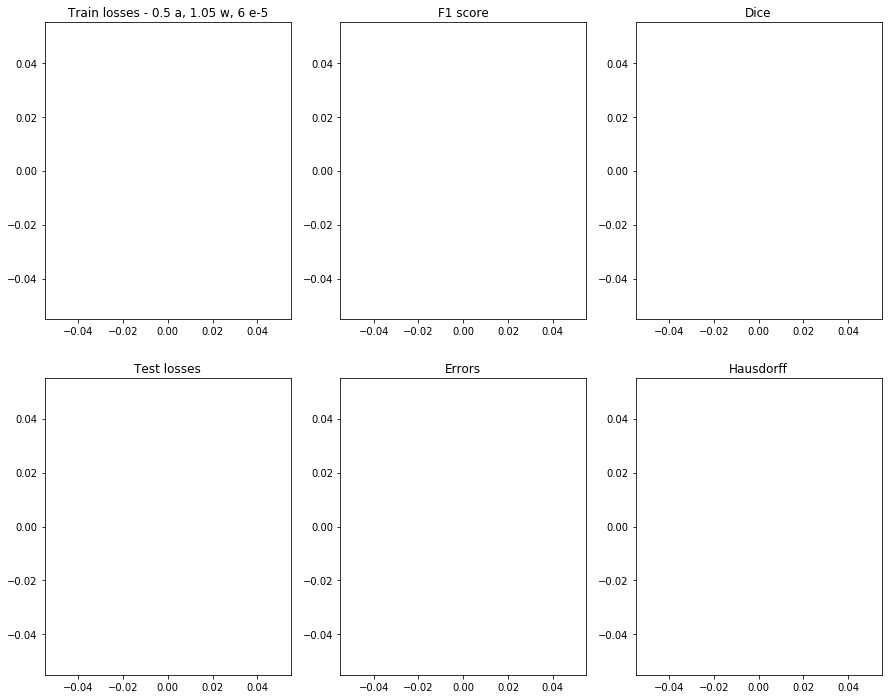

In [42]:
f, ((c1r1, c1r2, c1r3), (c2r1, c2r2, c2r3)) = plt.subplots(2, 3, sharey=False)
f.set_size_inches(15, 12)

c1r1.set_title("Train losses - 0.5 a, 1.05 w, 6 e-5")
sns.scatterplot(y = np.array(train_losses[:]),
                x = np.array([x for x in range(len(train_losses[:]))]),
               ax = c1r1)

c1r2.set_title("F1 score")
sns.scatterplot(y = np.array(f1s[:]),
                x = np.array([x for x in range(len(f1s[:]))]),
               ax = c1r2)

c2r1.set_title("Test losses")
sns.scatterplot(y = np.array(test_losses[:]),
                x = np.array([x for x in range(len(test_losses[:]))]),
               ax = c2r1)

c2r2.set_title("Errors")
sns.scatterplot(y = np.array(errors[:]),
                x = np.array([x for x in range(len(errors[:]))]),
               ax = c2r2)

c2r3.set_title("Hausdorff")
sns.scatterplot(y = np.array(hausdorff[:]),
                x = np.array([x for x in range(len(errors[:]))]),
               ax = c2r3)

c1r3.set_title("Dice")
sns.scatterplot(y = np.array(dices[:]),
                x = np.array([x for x in range(len(dices[:]))]),
               ax = c1r3)

plt.show()

In [43]:
# Make sure that the equibatch is working with the augmentation
randomize = equibatch(train_ids)
sum_no_equibatch = []
sum_equibatch = []
for k in tnrange(int(len(randomize) // 20)):
    rand = [x for x in range(len(randomize))]
    batch_ids = rand[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
    _, y_batch = augment_batch(batch_ids, BATCH_SIZE)
    sum_no_equibatch.append(np.sum(y_batch))
    
for k in tnrange(int(len(randomize) // 20)):
    batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
    _, y_batch = augment_batch(batch_ids, BATCH_SIZE)
    sum_equibatch.append(np.sum(y_batch))
    
print("No equibatch SD: {}".format(np.std(np.array(sum_no_equibatch))))
print("Equibatch SD: {}".format(np.std(np.array(sum_equibatch))))

[308, 104, 92, 86, 67, 122, 134, 168, 418]
1499



No equibatch SD: 543.2790555628795
Equibatch SD: 107.96937381952475


In [44]:
len(train_y)

1499

In [45]:
train_ids = [x for x in range(len(train_y))]
#train_ids = [x for x in range(440, 505)]

# September changes
- Implement equibatch
- Implement 4x4 FPA, with CSSE in middle blocks
- Reduce label smoothing from 0.08 to 0.03
- reduce dropblock to 0.95 from 0.8

# Things to test
- Concatenating mean after GRU
- Turning of sse in GRU

In [46]:
### import scipy
best_val = 0.5
fine_tune = False
countries['all'] = [0, len(test_x)]
ft_epochs = 0
ft_learning_rate = 5e-3

for i in range(1, 100):
    #al = 0.33
    al = np.min( [0.015 * (i - 1), 0.5] )
    be = 0.0
    #be = np.max([((i / 100) - 0.33 ) + ((i - 33) * 0.02), 0])
    #al = np.min([0.0 + (i - 50) * 0.02, 0.8])
    #al = 1.0
    if al < 0.8:
        test_al = 0.5
    else:
        test_al = al
    if fine_tune == True:
        op = ft_op
        ft_epochs += 1
        if ft_epochs % 25 == 0:
            ft_learning_rate /= 2
        print("FINE TUNING WITH {} LR".format(ft_learning_rate))
        
    else:
        op = op = train_op
    randomize = equibatch(train_ids)
    print("starting epoch {}, alpha: {}, beta: {} drop: {}".format(i, al, be, np.max((1. - (i*0.0075), 0.80))))
   # print(f"BCE: {1 - al}, LOVASZ: {al * (1 - 2*al)}, SURFACE: {al * (2*al)}")
    #print(np.max([1.9 - (i * 0.015), 1.3]))
    
    loss = train_loss
    BATCH_SIZE = 20
    test_ids = [x for x in range(0, len(test_x))]
    losses = []
    
    for k in tnrange(int(len(randomize) // BATCH_SIZE)):
        rmax_epoch, dmax_epoch, rmin_epoch = calc_renorm_params(i, 5000, 20, k)
        if k % 8 == 0:
            sleep(1)
        batch_ids = randomize[k*BATCH_SIZE:(k+1)*BATCH_SIZE]
        x_batch, y_batch = augment_batch(batch_ids, BATCH_SIZE)
        opt, tr = sess.run([op, loss],
                          feed_dict={inp: x_batch,
                                     length: train_l[batch_ids].reshape((-1, 1)),
                                     labels: y_batch,
                                     is_training: True,
                                     clipping_params['rmax']: rmax_epoch,
                                     clipping_params['rmin']: rmin_epoch,
                                     clipping_params['dmax']: dmax_epoch,
                                     loss_weight: 1.00,
                                     #loss_weight: np.max([1.9 - (i * 0.015), 1.3]), 
                                     keep_rate: np.max((1. - (i * 0.0075), 0.8)),
                                     alpha: al,
                                     beta_: be,
                                     ft_lr: ft_learning_rate,
                                     })
        losses.append(tr)
    
    print("Epoch {}: Loss {}".format(i, np.around(np.mean(losses[:-1]), 3)))
    
    # _, _, _, _, _, _ = calculate_metrics("global-test", al = al)
    val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)
    train_losses.append(np.mean(losses[:-1]))
    test_losses.append(val_loss)
    f1s.append(f1)
    dices.append(dice)
    errors.append(error)
    hausdorff.append(haus)
    if f1 > (best_val - 0.0065):
        print("Saving model with {}".format(dice))
        os.mkdir("../models/sept-29/{}-{}-{}/".format(str(i), str(f1*100)[:2], str(f1*100)[3]))
        save_path = saver.save(sess, "../models/sept-29/{}-{}-{}/model".format(str(i), str(f1*100)[:2], str(f1*100)[3]))
        if f1 > best_val:
            best_val = f1
    

[308, 104, 92, 86, 67, 122, 134, 168, 418]
1499
starting epoch 1, alpha: 0.0, beta: 0.0 drop: 0.9925



Epoch 1: Loss 0.5329999923706055
75


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


all: Val loss: 0.20100000500679016 Thresh: 0.4 F1: 0.839 R: 0.911 P: 0.777 D: 0.6161643171472898 H: 0.957 Error: 18.139
Saving model with 0.6161643171472898


FileNotFoundError: [Errno 2] No such file or directory: '../models/sept-29/1-83-8/'

In [ ]:
calc_renorm_params(30, 5000, 20, 0)

In [ ]:
# 100% Surf =  -0.165
# 100% LOV = 0.32

In [ ]:
#val_loss, f1, error, haus, dice = calculate_metrics('all', al = test_al, canopy_thresh = 75)
os.mkdir("../models/5e-5/1-10bce/{}-{}-{}".format(str(34), str(f1*100)[:2], str(f1*100)[3]))
save_path = saver.save(sess, "../models/5e-5/1-10bce/{}-{}-{}/model".format(str(34), str(f1*100)[:2], str(f1*100)[3]))

# Model validation and sanity checks





In [ ]:
preds2 = np.concatenate(preds).flatten()
trues2 = np.concatenate(trues).flatten()
tp = preds2 * trues2
fn = [1 if x > y else 0 for (x, y) in zip(trues2, preds2)]
fp = [1 if y > x else 0 for (x, y) in zip(trues2, preds2)]
tn = (len(test_y) * 196) - np.sum(tp) - np.sum(fn) - np.sum(fp)
print("TP {}, FN {}, FP {}, TN {}".format(np.sum(tp), sum(fn), np.sum(fp), tn))
print(len(preds2))

In [ ]:
tps = []
fns = []
fps = []
for i in range(0, len(test_y)*196, 196):
    tps.append(np.sum(tp[i:i+196]))
    fns.append(np.sum(fn[i:i+196]))
    fps.append(np.sum(fp[i:i+196]))

In [ ]:
from sklearn.metrics import f1_score

true_canopy = []
error_canopy = []
pred_canopy = []
f1_hard = []
tp_softs = []
fp_softs = []
fn_softs = []
for i in range(len(trues)):
    true_canopy.append(np.sum(trues[i]) / 1.96)
    error_canopy.append(abs(np.sum(preds[i]) - np.sum(trues[i])) / 1.96)
    pred_canopy.append(np.sum(preds[i]) / 1.96)
    f1_hard.append(f1_score(trues[i], preds[i]))
    tp_soft, fp_soft, fn_soft = compute_f1_score_at_tolerance(np.array(trues[i].reshape((14, 14))),
                                                 np.array(preds[i].reshape((14, 14))))
    tp_softs.append(tp_soft)
    fp_softs.append(fp_soft)
    fn_softs.append(fn_soft)

In [ ]:
precision = np.sum(tp_softs) / (np.sum(tp_softs) + np.sum(fp_softs))
recall = np.sum(tp_softs) / (np.sum(tp_softs) + np.sum(fn_softs))
print(precision, recall, np.mean(error_canopy), np.mean(true_canopy), np.mean(pred_canopy))

In [ ]:
plot_ids_loaded = np.load("../data/metrics/plotids.npy")
plot_ids_loaded = np.delete(plot_ids_loaded, outliers, 0)

In [ ]:
metrics = pd.DataFrame({'true': true_canopy,
                        'pred': pred_canopy,
                        'f1_hard': f1_hard,
                        'error': error_canopy,
                        'tp': tps,
                        'fp': fps,
                        'fn': fns,
                        'tp_soft': tp_softs,
                        'fp_soft': fp_softs,
                        'fn_soft': fn_softs,
                       })

res = map(lambda x: int(math.floor(np.min([x, 90]) / 10.0)) * 10, true_canopy)
res = [x for x in res]
metrics['group'] = res
metrics['model'] = 'proposed'
#metrics['slope'] = slopes
metrics['plot_id'] = plot_ids_loaded
metrics.to_csv("../data/metrics/proposed-sample.csv")

In [ ]:
metrics = pd.read_csv("../data/metrics/proposed-sample.csv")
continents = pd.read_csv("../data/latlongs/test_continents.csv")
continents = continents.join(metrics, how = 'inner')
continents.groupby("CONTINENT").mean()

In [ ]:
hard_precisions = metrics.groupby('group').apply(lambda x: (np.sum(x.tp) / np.sum(x.tp + x.fp)))
hard_recalls = metrics.groupby('group').apply(lambda x: (np.sum(x.tp) / np.sum(x.tp + x.fn)))
errors = metrics.groupby('group').apply(lambda x: np.mean(x.error))
hard_f1 = 2 *  ((hard_precisions * hard_recalls) / (hard_precisions + hard_recalls))

precisions = metrics.groupby('group').apply(lambda x: (np.sum(x.tp_soft) / np.sum(x.tp_soft + x.fp_soft)))
recalls = metrics.groupby('group').apply(lambda x: (np.sum(x.tp_soft) / np.sum(x.tp_soft + x.fn_soft)))
soft_f1 = 2 *  ((precisions * recalls) / (precisions + recalls))

In [ ]:
new_metrics = pd.DataFrame({'group': [x for x in range(0, 100, 10)],
                            'hard_rec': hard_recalls,
                            'soft_rec': recalls,
                            'hard_prec': hard_precisions,
                            'soft_prec': precisions,
                            'hard_f1': hard_f1,
                            'soft_f1': soft_f1,
                            'error': errors,
                            'model': 'proposed'
                           })

#new_metrics.to_csv("../data/metrics/proposed.csv")

In [ ]:
rf = pd.read_csv("../data/metrics/rf.csv")
svm = pd.read_csv("../data/metrics/svm.csv")
unet = pd.read_csv("../data/metrics/unet.csv")
new_metrics = pd.read_csv("../data/metrics/proposed.csv")
metrics = pd.concat([new_metrics, unet, svm, rf])

#rf = pd.read_csv("../data/metrics/random_forest.csv")
svm = pd.read_csv("../data/metrics/svm-sample.csv")
unet = pd.read_csv("../data/metrics/unet-sample.csv")
proposed = pd.read_csv("../data/metrics/proposed-sample.csv")
rf = pd.read_csv("../data/metrics/rf-sample.csv")
#metrics['model'] = 'proposed'
sample = pd.concat([proposed, unet, svm, rf])



In [ ]:
# Hard F1, Soft F1, Error
f, ((c1r1, c1r2, c1r3)) = plt.subplots(1, 3, sharey=False)
f.set_size_inches(20, 8.5)
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

c1r1.set_title("User's accuracy")
one = sns.pointplot(x = 'group', y= 'soft_prec',
    data=metrics, hue = 'model', ax = c1r1)#, style = 'variable')
one.set_xticklabels(rotation=45, labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59',
                     '60-69', '70-79', '80-89', '90-100'])
one.set(xlabel='Tree cover (of 140 x 140 m plot)', ylabel = "User's accuracy")
one.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
one.legend(fontsize='small')

c1r2.set_title("Producer's accuracy")
two = sns.pointplot(x = 'group', y= 'soft_rec',
    data=metrics, hue = 'model', ax = c1r2)
two.set_xticklabels(rotation=45, labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59',
                     '60-69', '70-79', '80-89', '90-100'])
two.set(xlabel='Tree cover (of 140 x 140 m plot)', ylabel = "Producer's accuracy")
two.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])


c1r3.set_title("Absolute % Error")
three = sns.pointplot(x = 'group', y= 'error',
    data=sample, hue = 'model', ax = c1r3)#, style = 'variable')
three.set_xticklabels(rotation=45, labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59',
                     '60-69', '70-79', '80-89', '90-100'])
three.set(xlabel='Tree cover (of 140 x 140 m plot)', ylabel = "Absolute error (%)")
three.set_yticks([0, 5, 10, 15, 20, 25, 30,35, 40,45, 50])

sns.set_style("whitegrid")
two.legend_.remove()
three.legend_.remove()
#plt.show()
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('../references/pdf/figure9.pdf')


# Prediction visualizations

In [ ]:
test_ids = [x for x in range(len(test_x))]
diffs = []
for idx in tnrange(len(test_ids)):
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: test_lengths[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    y[np.where(y > 0.5)] = 1.0
    y[np.where(y < 0.5)] = 0.
    diff = np.sum(y) - np.sum(test_y[idx])
    diffs.append(diff)

In [ ]:
start = 0

test_ids = [x for x in range(0, len(test_x))]

def multiplot(matrices, nrows = 2, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(20, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i, matrix in enumerate(matrices[min_i:max_i]):
            sns.heatmap(data = matrix, ax = axs[r - 1, i], vmin = 0, vmax = 0.9)
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
    plt.show



In [ ]:
def identify_alignment(true, pred, wsize = 3, difference = 0.2):
    '''Docstring
    
         Parameters:
          true (arr):
          pred (arr):
          wsize (int):
          difference (float):
          
         Returns:
          None
    '''
    n_single_trees = 0
    for x in range(1, true.shape[0] - 1, 1):
        for y in range(1, true.shape[1] - 1, 1):
            wind_true = true[x-1:x+2, y-1:y+2]
            wind_pred = pred[x-1:x+2, y-1:y+2]
            if wind_true[1, 1] == 1:
                if np.sum(wind_true) == 1:
                    n_single_trees += 1
                    pred_place = np.argmax(wind_pred.flatten())
                    diff = wind_pred.flatten()[pred_place] - wind_pred.flatten()[4]
                    if pred_place != 4:
                        if diff > difference:
                            x_lv = pred_place // 3
                            y_lv = pred_place % 3
                            print(x_lv, y_lv)
                            proposed = wind_true[x_lv - 1:x_lv+2, y_lv-1:y_lv+2]
                            if np.sum(proposed) == 0:
                                print("There is a missed position at {} x, {} y: {}".format(x, y, diff))

In [ ]:
def aggregate_maxes(y_true, y_pred):
    y_out = np.copy(y_pred)
    change_map = np.zeros((14, 14))
    for x in range(y_true.shape[0]):
        for y in range(y_true.shape[0]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([y_true.shape[1], y+2])
            max_x = np.min([y_true.shape[1], x+2])
            
            y_true_sum = np.sum(y_true[min_x:max_x, min_y:max_y])
            y_pred_max = np.max(y_pred[min_x:max_x, min_y:max_y])
            y_pred_min = np.min(y_pred[min_x:max_x, min_y:max_y])
            
    
            if y_true[x, y] == 1: # if positive and unsure
                if y_true_sum < 9: # if edge and there is a candidate
                    diffs = y_pred_max - y_pred[x, y]
                    percentage = np.min([1/(1 + np.exp(-(diffs * 10 - 5))), 0.5])
                    y_out[x, y] += percentage
                    change_map[x, y] = percentage
            if y_true[x, y] == 0:# and y_pred[x, y] > 0.75: # if negative and unsure
                if y_true_sum > 0: #and y_pred_min < 0.25: # if edge and there is a candidate
                    diffs = y_pred[x, y] - y_pred_min
                    percentage = np.min([1/(1 + np.exp(-(diffs * 10 - 5))), 0.5])
                    y_out[x, y] -= percentage #= np.min(y_pred[min_x:max_x, min_y:max_y])
                    change_map[x, y] = -percentage
    return y_out, change_map



In [ ]:
from sklearn.metrics import f1_score
print(start/len(test_ids))
test_ids = sorted(test_ids)
#start = 8
to_test = [681, 684, 689, 732, 791, 798, 802, 877, 905, 947, 951, 964, 965, 966, 997, 1094, 1101]
matrix_ids = [test_ids[start], test_ids[start + 1], test_ids[start + 2], test_ids[start + 3],
              test_ids[start + 4], test_ids[start + 5], test_ids[start + 6], test_ids[start + 7]]
#matrix_ids = np.argwhere(abs(np.array(diffs)) > 100)[8 + 8 + 8 + 8 : 8 + 8 + 8 + 8 + 8]

preds = []
trues = []
print(matrix_ids)
for i in matrix_ids:
    #print(plot_ids_loaded[i])
    idx = i
    y = sess.run([fm], feed_dict={inp: test_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    #y, mapshape = aggregate_maxes(test_y[idx], y)
    preds.append(y)
    y2 = np.copy(y)
    print(np.mean(dice_loss(test_y[idx], y)), np.mean(dice_loss_tolerance(test_y[idx], y)))
    #surf_distances = 
    #y[np.where(y > 0.4)] = 1.0
    #y[np.where(y < 0.4)] = 0.
    #y[np.where(y >= 0.4)] = 1.
    #dc = np.around(dice_loss(test_y[idx].flatten(), y2.flatten()), 3)
    true = test_y[idx].reshape(14, 14)
    trues.append(true)


to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]

multiplot(to_plot, nrows = 4, ncols = 4)


start = start + 8 



# 220, ""

\def compute_f1_score_at_tolerance(true, pred, tolerance = 1):
    fp = 0
    tp = 0
    fn = 0
    true = true.reshape((14, 14))
    pred = pred.reshape((14, 14))
    
    tp = np.zeros_like(true)
    fp = np.zeros_like(true)
    fn = np.zeros_like(true)
    
    
    
    for x in range(true.shape[0]):
        for y in range(true.shape[1]):
            min_x = np.max([0, x-1])
            min_y = np.max([0, y-1])
            max_y = np.min([true.shape[0], y+2])
            max_x = np.min([true.shape[0], x+2])
            if true[x, y] == 1:
                if np.sum(pred[min_x:max_x, min_y:max_y]) > 0:
                    if pred[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fn[x, y] = 1
            if pred[x, y] == 1:
                if np.sum(true[min_x:max_x, min_y:max_y]) > 0:
                    if true[x, y] == 1:
                        tp[x, y] = 1
                else:
                    fp[x, y] = 1
    precision =  np.sum(tp) / (np.sum(tp) + np.sum(fp))
    recall = np.sum(tp) / (np.sum(tp) + np.sum(fn))
    f1 = 2 * ((precision * recall) / (precision + recall))

    return f1


In [ ]:
diffs = []
for idx in tnrange(len(train_ids)):
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                  })
    y = np.array(y).reshape(14, 14)
    y[np.where(y > 0.5)] = 1.0
    y[np.where(y < 0.5)] = 0.
    diff = np.sum(y) - np.sum(train_y[idx])
    diffs.append(diff)

In [ ]:
train_ids = [x for x in range(train_x.shape[0])]
train_ids = sorted(train_ids)
start = len(train_ids) - 24

In [ ]:
##matrix_ids = [70, 139, 456, 630, 718, 800, 835, 1101]
#matrix_ids = np.argwhere(abs(np.array(diffs)) > 75)[8 + 8 + 8 + 8 + 8 + 8 + 8 +8 +8 + 8 + 8 + 8 + 8 + 8:
#                                                    8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8 + 8+ 8 + 8 + 8 + 8]

matrix_ids = [train_ids[start], train_ids[start + 1], train_ids[start + 2],
              train_ids[start + 3], train_ids[start + 4],
             train_ids[start + 5], train_ids[start + 6], train_ids[start + 7]]
#matrix_ids = [358, 425, 459, 516, 625, 705, 1065]
preds = []
trues = []
#print(start//4)
print(matrix_ids)
for i in matrix_ids:
    idx = i
    y = sess.run([fm], feed_dict={inp: train_x[idx].reshape(1, 24, IMAGE_SIZE, IMAGE_SIZE, n_bands),
                                  length: train_l[idx].reshape(1, 1),
                                  is_training: False,
                                  clipping_params['rmax']: rmax_epoch,
                                  clipping_params['rmin']: rmin_epoch,
                                  clipping_params['dmax']: dmax_epoch,
                                    })
    y = np.array(y).reshape(14, 14)
    
    #y, _ = aggregate_maxes(train_y[idx], y)
    
    preds.append(y)
    true = train_y[idx].reshape(14, 14)
    #print(np.mean(dice_loss(train_y[idx], y)), np.mean(dice_loss_tolerance(train_y[idx], y)))
    #identify_alignment(true, y)
    
    trues.append(true)
    
start += 8

to_plot = trues[0:4] + preds[0:4] + trues[4:] + preds[4:]
multiplot(to_plot, nrows = 4, ncols = 4)

[1, ]

In [ ]:
len(train_ids)